### SABR Model — Deep BSDE Approach

We consider the forward dynamics under the SABR model:

$$
\begin{cases}
dF_t = \alpha_t F_t^\beta\, dW_t \\
d\alpha_t = \nu \alpha_t\, dZ_t \\
dW_t dZ_t = \rho\, dt
\end{cases}
$$

Our goal is to compute the conditional expectation:

$$
u(t, F_t, \alpha_t) = \mathbb{E}[(F_T - K)^+ \mid \mathcal{F}_t].
$$

Since $u$ is a martingale under the risk-neutral measure, its BSDE has no drift term:

$$
du = \alpha_t F_t^\beta\, u_F\, dW_t + \nu \alpha_t\, u_\alpha\, dZ_t.
$$

Discretizing this equation in time using Euler steps gives:

$$
u_{n+1} \approx u_n + \alpha_n F_n^\beta\, u_F\, \Delta W_n + \nu \alpha_n\, u_\alpha\, \Delta Z_n.
$$

In our Deep BSDE implementation:

1. We sample $N$ steps of correlated Brownian motions $\{\Delta W_n\}, \{\Delta Z_n\}$ using Cholesky decomposition.

2. We initialize the SABR state $(F_0, \alpha_0)$ by uniform sampling over specified ranges.

3. A neural network `u0_net` estimates the initial option price $u(0, F_0, \alpha_0)$, while another network `z0_net` estimates the initial gradient $(u_F, u_\alpha)$.

4. We propagate the BSDE forward in time:

   * At each step, we update the solution $y_n$ using the BSDE formula.
   * We evolve $F_n$ and $\alpha_n$ forward using their SDEs.
   * At every step $n < N-1$, a separate neural net $\text{z\_nets}[n]$ estimates the gradients $(u_F, u_\alpha)$ at the new state.

5. At terminal time $T$, we compute the residual between $y_N$ and the true payoff $\max(F_T - K, 0)$, and train the model to minimize this residual.

The model is trained using mean squared error loss, targeting zero residuals. Once trained, we can use `u0_net` to directly estimate the option price at $t = 0$ given any $(F_0, \alpha_0)$ input.




In [ ]:
import math, time
import torch, torch.nn as nn, torch.optim as optim

# set ranges and constants
F_min, F_max = 85.0, 115.0    # forward price range
A_min, A_max = 0.05, 0.15     # alpha range
beta = 0.7                    # SABR beta
nu, rho = 0.4, -0.3           # vol-of-vol and correlation
K = 100.0                     # strike price
T, N = 1.0, 100               # maturity and time steps
dt, sqrt_dt = T/N, math.sqrt(T/N)
paths = 4096                  # number of Monte Carlo paths
hidden = 64                   # hidden layer size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)   # first linear layer
        self.bn1 = nn.BatchNorm1d(hidden_dim)      # batch normalization
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)  # output layer
        self.relu = nn.ReLU()                      # activation

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))       # apply first layer + BN + ReLU
        x = self.relu(self.bn2(self.fc2(x)))       # apply second layer + BN + ReLU
        x = self.fc3(x)                            # produce output
        return x

class DeepBSDE_SABR(nn.Module):
    def __init__(self):
        super().__init__()
        # network at t=0 for (u_F, u_alpha)
        self.z0_net = MLP(in_dim=2, hidden_dim=hidden, out_dim=2)
        # one network per time step for (u_F, u_alpha)
        self.z_nets = nn.ModuleList(
            MLP(in_dim=2, hidden_dim=hidden, out_dim=2) for _ in range(N-1)
        )
        # network at t=0 for y0
        self.u0_net = MLP(in_dim=2, hidden_dim=hidden, out_dim=1)
        # Cholesky factor to correlate dW and dZ
        chol = torch.tensor([[1.0, 0.0], [rho, math.sqrt(1 - rho**2)]])
        self.register_buffer("chol", chol)

    def _dW_dZ(self, batch):
        # sample independent normals and correlate them
        eps = torch.randn(batch, 2, N, device=device)
        inc = torch.einsum('ij,bjn->bin', self.chol, eps) * sqrt_dt
        return inc[:, 0], inc[:, 1]  # return dW, dZ

    def forward(self, batch_size):
        # generate correlated Brownian increments
        dW, dZ = self._dW_dZ(batch_size)
        # sample initial F and alpha
        F = F_min + torch.rand(batch_size, device=device) * (F_max - F_min)
        a = A_min + torch.rand(batch_size, device=device) * (A_max - A_min)
        x = torch.stack((F, a), dim=1)

        # initialize y and z = (u_F, u_alpha) at t=0
        y = self.u0_net(x).squeeze()
        z = self.z0_net(x)

        # step through time
        for n in range(N):
            # update y using BSDE formula
            y = y + a * F.pow(beta) * z[:, 0] * dW[:, n] \
                  + nu * a * z[:, 1] * dZ[:, n]

            # evolve variables F and alpha
            F = F + a * F.pow(beta) * dW[:, n]
            a = a + nu * a * dZ[:, n]

            # predict next z if not at final step
            if n < N-1:
                x = torch.stack((F, a), dim=1)
                z = self.z_nets[n](x)

        # compute payoff and return the difference
        payoff = torch.relu(F - K)
        return y - payoff

# training loop
model = DeepBSDE_SABR().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

epochs = 1500
for ep in range(epochs):
    diff = model(paths)                          # BSDE residuals
    loss = criterion(diff, torch.zeros_like(diff))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 100 == 0:
        print(f"Epoch {ep:4d}  loss={loss.item():.4e}")

model.eval()                                    # switch to eval mode
with torch.no_grad():
    # estimate price at a given (F, alpha) point
    price = model.u0_net(torch.tensor([[101, 0.05]], device=device)).item()
print(f"\nOption price at t=0 ≈ {price:.4f}")

torch.save(model.state_dict(), "deepbsde_sabr.pth")


Epoch    0  loss=4.4293e+01
Epoch  100  loss=1.2011e+01
Epoch  200  loss=3.0056e+00
Epoch  300  loss=2.4761e-01
Epoch  400  loss=4.5671e-02
Epoch  500  loss=2.9795e-02
Epoch  600  loss=2.5188e-02
Epoch  700  loss=5.1100e-02
Epoch  800  loss=1.6152e-02
Epoch  900  loss=2.5570e-02
Epoch 1000  loss=1.3896e-02
Epoch 1100  loss=3.2856e-02
Epoch 1200  loss=1.1346e-02
Epoch 1300  loss=1.4648e-02
Epoch 1400  loss=2.6602e-02

Option price at t=0 ≈ 1.3903


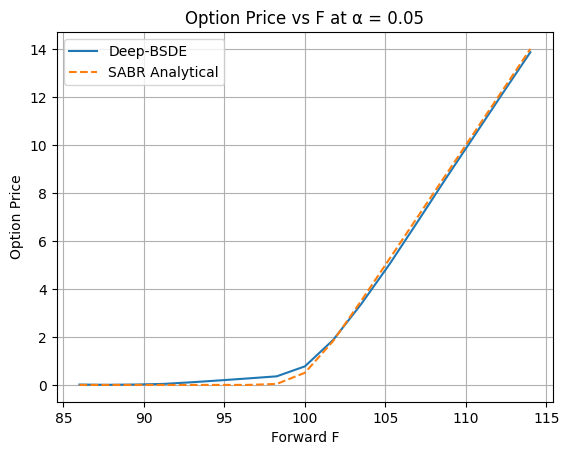

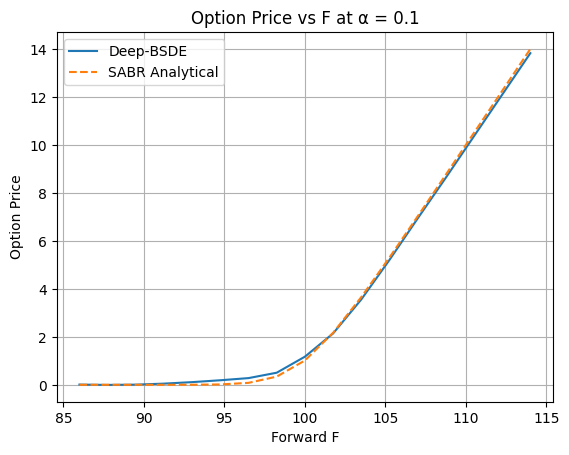

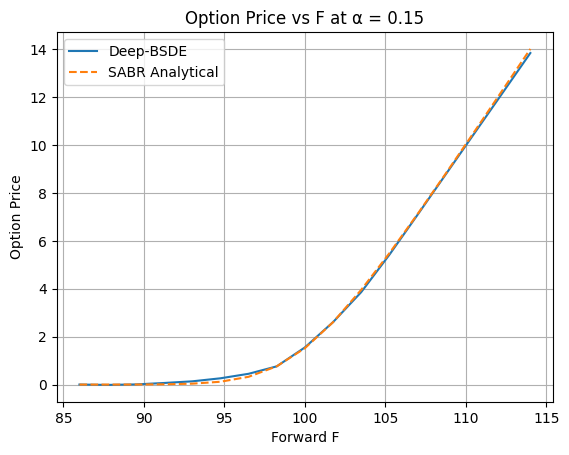

In [ ]:
import os, math, numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn
from torch.distributions.normal import Normal

# Hagan Helper function SABR Vol -> BS
def hagan_implied_vol(F, K, T, alpha, beta, rho, nu, eps=1e-12):
    if abs(F - K) < eps:  # ATM
        fk_beta = F ** (1 - beta)
        term1 = alpha / fk_beta
        term2 = ((1 - beta) ** 2 / 24) * (alpha ** 2) / fk_beta ** 2
        term3 = (rho * beta * nu * alpha) / (4 * fk_beta)
        term4 = (2 - 3 * rho ** 2) * nu ** 2 / 24
        return term1 * (1 + (term2 + term3 + term4) * T)

    logFK = math.log(F / K)
    FK = F * K
    fk_beta = FK ** ((1 - beta) / 2)
    z = (nu / alpha) * fk_beta * logFK
    x_z = math.log((math.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    A = alpha / fk_beta
    B = 1 + ((1 - beta) ** 2 / 24) * logFK ** 2 + ((1 - beta) ** 4 / 1920) * logFK ** 4
    C = 1 + (
        ((1 - beta) ** 2 * alpha ** 2) / (24 * FK ** (1 - beta))
        + (rho * beta * nu * alpha) / (4 * FK ** ((1 - beta) / 2))
        + (2 - 3 * rho ** 2) * nu ** 2 / 24
    ) * T
    return (A / B) * (z / x_z) * C

def bs_call(F, K, T, sigma):
    N = Normal(0.0, 1.0)
    sqrtT = math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return F * N.cdf(torch.tensor(d1)) - K * N.cdf(torch.tensor(d2))

#  Deep‑BSDE network initialization
hidden, N = 64, 100
beta, nu, rho = 0.7, 0.4, -0.3
T, K = 1.0, 100.0
sqrt_dt = math.sqrt(T / N)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

class DeepBSDE_SABR(nn.Module):
    def __init__(self):
        super().__init__()
        self.u0_net = MLP(2, hidden, 1)
        self.z0_net = MLP(2, hidden, 2)
        self.z_nets = nn.ModuleList([MLP(2, hidden, 2) for _ in range(N - 1)])
        chol = torch.tensor([[1.0, 0.0], [rho, math.sqrt(1 - rho ** 2)]])
        self.register_buffer("chol", chol)

# Load trained model
device = torch.device("cpu")
model_path = "deepbsde_sabr.pth"
deep_price_fn = None

net = DeepBSDE_SABR().to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
@torch.no_grad()
def deep_price(F0, A0):
    x = torch.tensor([[F0, A0]], dtype=torch.float32, device=device)
    return net.u0_net(x).item()
deep_price_fn = deep_price

# pricing grid
F_vals = np.linspace(86, 114, 17)  # 60 → 140 step 5
alpha_list = [0.05, 0.10, 0.15]
# Plot analytical vs Predicted
for alpha in alpha_list:
    model_prices, analytic_prices = [], []
    for F0 in F_vals:
        sigma = hagan_implied_vol(F0, K, T, alpha, beta, rho, nu)
        analytic_prices.append(bs_call(F0, K, T, sigma).item())
        if deep_price_fn:
            model_prices.append(deep_price_fn(F0, alpha))
    # plot
    plt.figure()
    if deep_price_fn:
        plt.plot(F_vals, model_prices, label="Deep‑BSDE")
    plt.plot(F_vals, analytic_prices, linestyle="--", label="SABR Analytical")
    plt.title(f"Option Price vs F at α = {alpha}")
    plt.xlabel("Forward F")
    plt.ylabel("Option Price")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
results = []
alpha_list = [0.05, 0.8, 0.1]
# get the error matrix
for alpha in alpha_list:
    abs_err_list = []
    pct_err_list = []
    for F0 in F_vals:
        sigma = hagan_implied_vol(F0, K, T, alpha, beta, rho, nu)
        analytic = bs_call(F0, K, T, sigma).item()
        pred = deep_price(F0, alpha)
        abs_err = abs(pred - analytic)
        abs_err_list.append(abs_err)

        if analytic > 1e-1:
            pct_err = abs_err / analytic
            pct_err_list.append(pct_err)

    results.append({
        "alpha": alpha,
        "MAE": np.mean(abs_err_list),
        "Max Abs Err": np.max(abs_err_list),
        "Avg % Err": (np.mean(pct_err_list) * 100) if pct_err_list else None
    })

import pandas as pd
df = pd.DataFrame(results).round(6)
print(df)


   alpha       MAE  Max Abs Err  Avg % Err
0   0.05  0.141268     0.316340   7.925607
1   0.80  0.503176     0.907266   7.361549
2   0.10  0.104910     0.198329   7.563959
